In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from os.path import isfile, join, expanduser
from os import listdir
import sys
import numpy as np
sys.path.append("../src")  # relative path from notebooks/ to src/
import reflectivity_model.utils as utils
sample_name = '2layers'
path = '.'
onlyfiles_keys = [
    f for f in listdir(path)
    if isfile(join(path, f)) and f.endswith('.json') and f.startswith(sample_name) and '2layers' in f
]

print("Found files:", onlyfiles_keys)
data = []
# Load JSON
for file in onlyfiles_keys:
    full_path = join(path, file)
    with open(file) as f:
        data_temp = json.load(f)
    data.append(data_temp)

#energies = [float(e.split("_")[0]) for e in data["energy_pol_uni"]]
#layers = data["layers"]


Found files: ['2layers_reflectivity_model_config.json']


In [2]:
data

[{'energy_pol_uni': ['250.0_s',
   '284.0_s',
   '284.2_s',
   '284.6_s',
   '285.0_s',
   '285.5_s',
   '286.0_s',
   '286.5_s',
   '287.0_s',
   '287.7_s',
   '288.6_s'],
  'global_params': {'aoi_offset': {'fit': True,
    'x0': 0.7209397709356313,
    'bounds': [-1, 1]},
   'darkcurrent': {'fit': False, 'x0': 0.0},
   'a': {'fit': False, 'x0': 0.045},
   'b': {'fit': False, 'x0': 2.5e-05}},
  'fit_strategy': 'per_energy',
  'sigma_mode': 'model',
  'layers': [{'name': 'UL',
    'is_substrate': False,
    'fit_thickness': {'x0': 101.98979874236144,
     'delta': None,
     'bounds': [88, 102]},
    'fit_roughness': {'x0': 1.8768793042720338,
     'delta': None,
     'bounds': [0, 2]},
    'fit_nk_array': {'n_array': [0.002061536581221818,
      0.00045191935782081297,
      0.0003652498536507882,
      0.0009144723040193985,
      -0.005773320624726166,
      0.002146928860989051,
      0.0014881318000654587,
      0.0002625126127315659,
      0.0004749670817957606,
      0.000262469

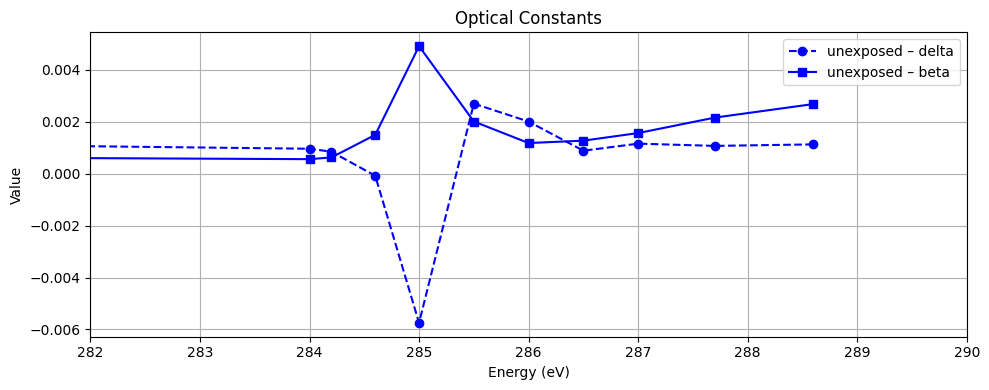

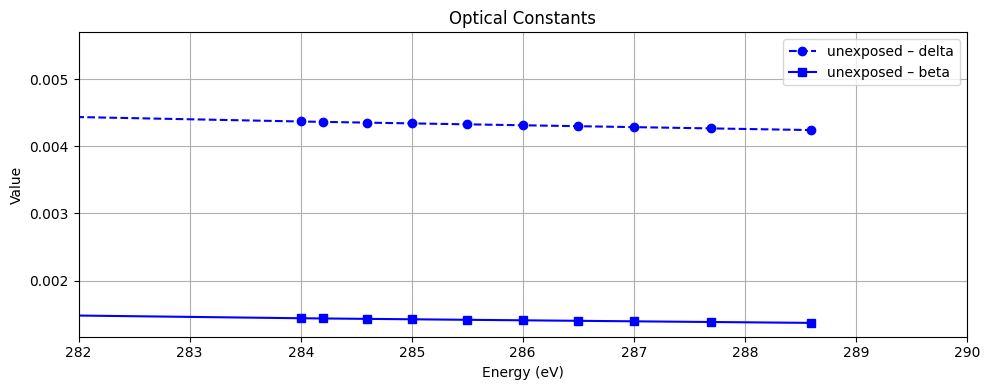

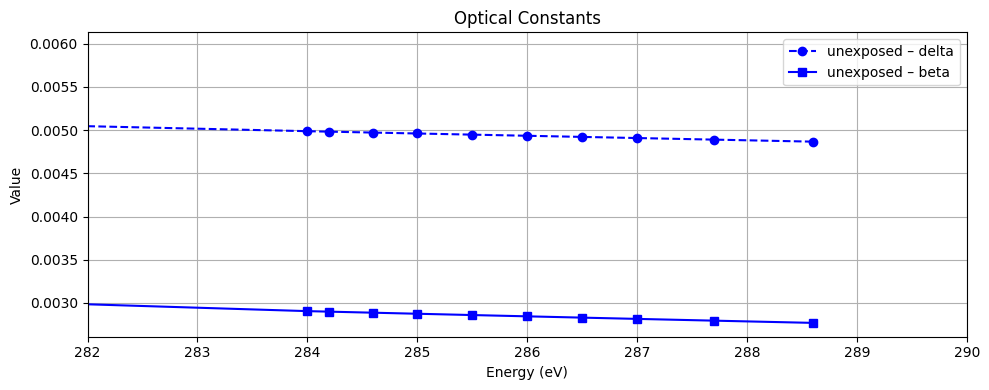

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Step 1: Group layers by name
layer_groups = defaultdict(list)

for sample in data:
    energies = [float(e.split("_")[0]) for e in sample["energy_pol_uni"]]
    #energies = sample.get("energies")
    for layer in sample.get("layers", []):
        name = layer.get("name")
        if name:
            layer_groups[name].append((layer, energies))
names = ['unexposed', 'exposed', 'PEB']  # Custom labels for each group
colors = ['blue', 'green', 'purple', 'orange']
for layer_key, layer_list in layer_groups.items():
    plt.figure(figsize=(10, 4))
    #label_name = names[i] #if i < len(names) else layer_key  # Fallback if names runs out

    for i,(layer, energies) in enumerate(layer_list):
        if "fit_nk_array" in layer:
            n = layer["fit_nk_array"]["n_array"]
            k = layer["fit_nk_array"]["k_array"]
        elif "fixed_nk" in layer:
            n = layer["fixed_nk"]["n_array"]
            k = layer["fixed_nk"]["k_array"]
        else:
            continue

        if n and k and len(n) == len(energies):
            plt.plot(energies, n,'--', label=f"{names[i]} – delta", marker="o",color=colors[i])
            plt.plot(energies, k, label=f"{names[i]} – beta", marker="s",color=colors[i])

    plt.title("Optical Constants")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Value")
    plt.legend()
    plt.xlim(282, 290)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [4]:
import numpy as np
from scipy.special import erf

def smooth_transition(z, z0, width, val1, val2):
    """Smooth transition between val1 and val2 centered at z0 with roughness width."""
    return val1 + (val2 - val1) * 0.5 * (1 + erf((z - z0) / (np.sqrt(2) * width)))

def get_thick_rough(layer):
    thickness = 0
    roughness = 0
    if "fit_thickness" in layer and "x0" in layer["fit_thickness"]:
        thickness = layer["fit_thickness"]["x0"]
    elif "fixed_thickness" in layer:
        thickness = layer["fixed_thickness"]

    if "fit_roughness" in layer and "x0" in layer["fit_roughness"]:
        roughness = layer["fit_roughness"]["x0"]
    elif "fixed_roughness" in layer:
        roughness = layer["fixed_roughness"]
    return thickness, roughness

def get_nk(layer,target_energy_index=0):
    if "fit_nk_array" in layer:
        n = layer["fit_nk_array"]["n_array"][target_energy_index]
        k = layer["fit_nk_array"]["k_array"][target_energy_index]
    else:
        n = layer["fixed_nk"]["n_array"][target_energy_index]
        k = layer["fixed_nk"]["k_array"][target_energy_index]
    return n, k
    


def build_centered_erf_profile(layers, energies, target_energy_index=0, resolution=0.1):
    # Parameters
    vacuum_thickness = 10
    substrate_extension = 10
    vacuum_n, vacuum_k = 0.0, 0.0

    # Compute total stack thickness
    stack_thickness = sum(
        layer.get("fit_thickness", {}).get("x0", layer.get("fixed_thickness", 0))
        for layer in layers
    )
    total_depth = vacuum_thickness + stack_thickness + substrate_extension
    z_grid = np.arange(-vacuum_thickness, stack_thickness + substrate_extension, resolution)

    n_profile = np.full_like(z_grid, vacuum_n, dtype=float)
    k_profile = np.full_like(z_grid, vacuum_k, dtype=float)



    z_current = 0
    prev_n, prev_k = vacuum_n, vacuum_k

    for i, layer in enumerate(layers[:-1]):
        #print(layer)
        #thickness = layer.get("fit_thickness").get("x0", layer.get("fixed_thickness"))
        #roughness = layer.get("fit_roughness").get("x0", layer.get("fixed_roughness"))
        thickness, roughness = get_thick_rough(layer)
        n_val, k_val = get_nk(layer,target_energy_index=target_energy_index)

        # Fill interior of layer
        for j, z in enumerate(z_grid):
            if z_current <= z < z_current + thickness:
                n_profile[j] = n_val
                k_profile[j] = k_val

        # Apply smooth transition centered at interface
        z_interface = z_current
        width = roughness / 2
        for j, z in enumerate(z_grid):
            if z_interface - 3 * width < z < z_interface + 3 * width:
                alpha = 0.5 * (1 + erf((z - z_interface) / (np.sqrt(2) * width)))
                n_profile[j] = (1 - alpha) * prev_n + alpha * n_val
                k_profile[j] = (1 - alpha) * prev_k + alpha * k_val

        z_current += thickness
        prev_n, prev_k = n_val, k_val

    # Final transition to substrate extension
    last_layer = layers[-1]
    rough_substrate = last_layer.get("fit_roughness", {}).get("x0", last_layer.get("fixed_roughness", 0.01))
    #print(rough_substrate)
    sub_n, sub_k = get_nk(last_layer,target_energy_index=target_energy_index)
    z_interface = z_current
    width = rough_substrate / 2

    for j, z in enumerate(z_grid):
        if z_interface - 3 * width < z < z_interface + 3 * width:
            alpha = 0.5 * (1 + erf((z - z_interface) / (np.sqrt(2) * width)))
            n_profile[j] = (1 - alpha) * prev_n + alpha * sub_n
            k_profile[j] = (1 - alpha) * prev_k + alpha * sub_k
        elif z >= z_interface + 3 * width:
            n_profile[j] = sub_n
            k_profile[j] = sub_k

    return z_grid, n_profile, k_profile

In [5]:
onlyfiles_keys

['2layers_reflectivity_model_config.json']

4


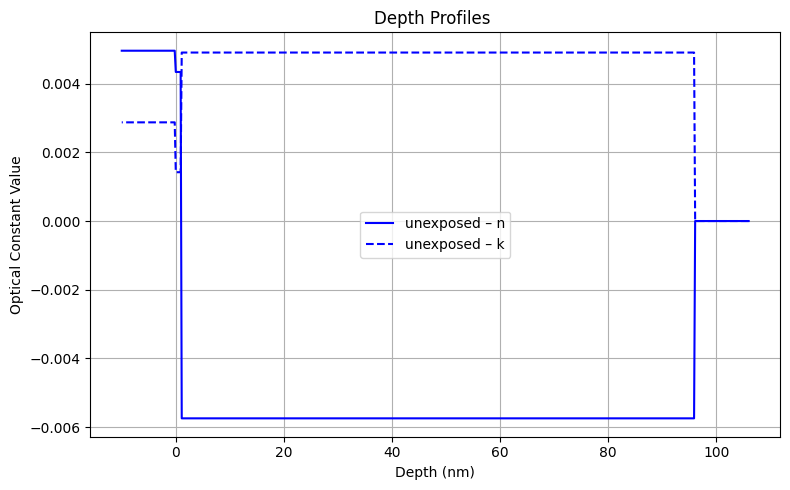

In [5]:
import matplotlib.pyplot as plt
names = ['unexposed', 'exposed', 'PEB']
colors = ['blue', 'green', 'purple', 'orange']  # Unique color per sample
target_energy_index = 5

plt.figure(figsize=(8, 5))

for i, entry in enumerate(data):
    matching_indices = [i for i, val in enumerate(entry['energy_pol_uni']) if "285" in val][0]
    print(matching_indices)
    z, n_vals, k_vals = utils.build_centered_erf_profile(
        entry["layers"], entry["energy_pol_uni"], target_energy_index=matching_indices
    )

    # Plot n and k with distinct styles
    plt.plot(-(z-np.max(z)+10), n_vals, label=f"{names[i]} – n", color=colors[i], linestyle='-')
    plt.plot(-(z-np.max(z)+10), k_vals, label=f"{names[i]} – k", color=colors[i], linestyle='--')

# Invert depth axis to show vacuum at top
#plt.gca().invert_xaxis()

# Labels and title
plt.xlabel("Depth (nm)")
plt.ylabel("Optical Constant Value")
plt.title("Depth Profiles ")

# Legend and grid
plt.legend()#ncol=1, fontsize='small')
plt.grid(True)
plt.tight_layout()



📁 Saved: unexposed_depth_profile_20250922_115155.csv


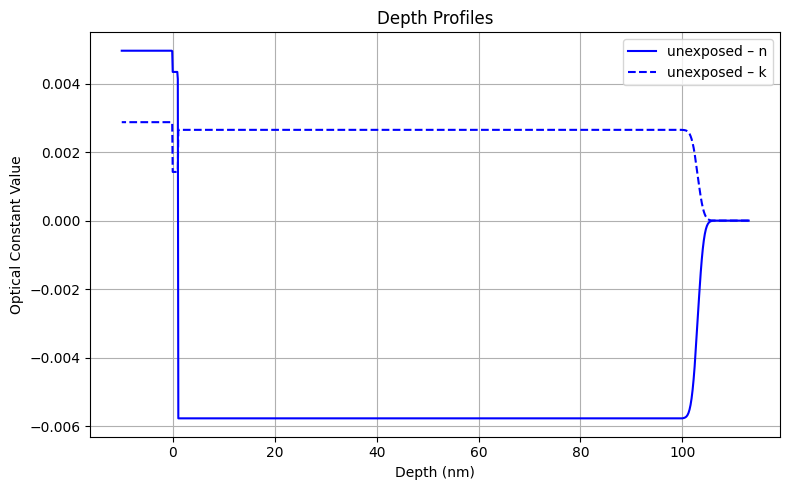

In [7]:
import pandas as pd
from datetime import datetime

names = ['unexposed', 'exposed', 'PEB']
colors = ['blue', 'green', 'purple', 'orange']
target_energy_index = 5

plt.figure(figsize=(8, 5))

for i, entry in enumerate(data):
    matching_indices = [j for j, val in enumerate(entry['energy_pol_uni']) if "285" in val]
    if not matching_indices:
        continue  # Skip if no match
    energy_index = matching_indices[0]

    z, n_vals, k_vals = build_centered_erf_profile(
        entry["layers"], entry["energy_pol_uni"], target_energy_index=energy_index
    )

    depth = -(z - np.max(z) + 10)  # Adjusted depth axis

    # Plot
    plt.plot(depth, n_vals, label=f"{names[i]} – n", color=colors[i], linestyle='-')
    plt.plot(depth, k_vals, label=f"{names[i]} – k", color=colors[i], linestyle='--')

    # Save to CSV
    df = pd.DataFrame({
        "Depth (nm)": depth,
        "n": n_vals,
        "k": k_vals
    })
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{names[i]}_depth_profile_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Final plot formatting
plt.xlabel("Depth (nm)")
plt.ylabel("Optical Constant Value")
plt.title("Depth Profiles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_colored_erf_profile(z_grid, n_profile, k_profile, layers, target_energy_index=0):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Generate distinct colors for each layer + substrate
    cmap = cm.get_cmap("tab10", len(layers) + 1)
    z_current = 0

    # Plot stack layers
    for i, layer in enumerate(layers[:-1]):
        thickness, _ = get_thick_rough(layer)
        color = cmap(i)
        label = layer.get("name", f"Layer {i+1}")

        z_start = z_current
        z_end = z_current + thickness
        ax.fill_betweenx(
            z_grid,
            n_profile.min(),
            n_profile.max(),
            where=(z_grid >= z_start) & (z_grid < z_end),
            color=color,
            alpha=0.2,
            label=label
        )
        z_current = z_end

    # Add substrate region
    substrate_color = cmap(len(layers))
    substrate_label = "Substrate"
    ax.fill_betweenx(
        z_grid,
        n_profile.min(),
        n_profile.max(),
        where=(z_grid >= z_current),
        color=substrate_color,
        alpha=0.2,
        label=substrate_label
    )

    # Plot n and k profiles
    ax.plot(n_profile, z_grid, label="delta", color="black", linewidth=2)
    ax.plot(k_profile, z_grid, '--', label="beta", color="black", linewidth=2)

    ax.invert_yaxis()
    ax.set_xlabel("Optical Constant Value")
    ax.set_ylabel("Depth (nm)")
    ax.set_title("📡 Colored Depth Profile of n and k with Smooth Transitions")
    ax.grid(True)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_687914/3903873371.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(layers) + 1)
/tmp/ipykernel_687914/3903873371.py:53: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kas/Projects/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128225 (\N{SATELLITE ANTENNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


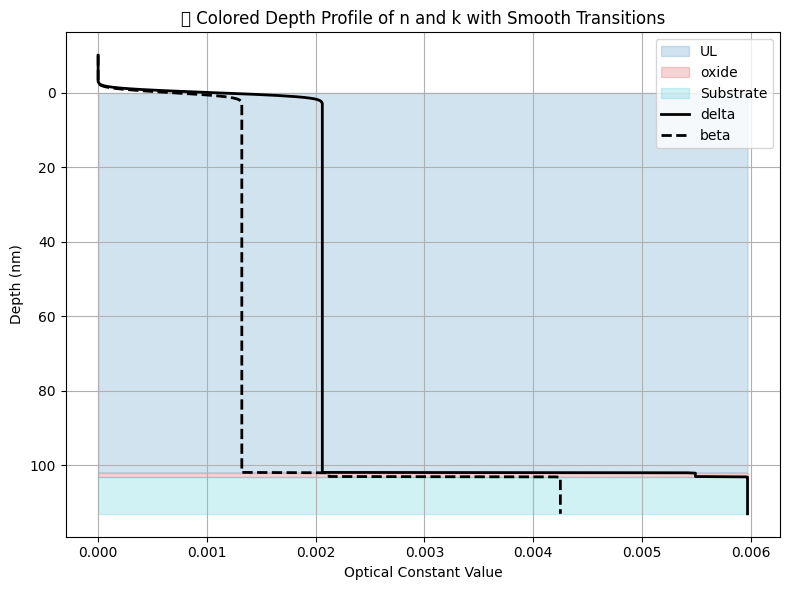

In [12]:
z, n_vals, k_vals = build_centered_erf_profile(
    data[0]["layers"], data[0]["energy_pol_uni"], target_energy_index=0
)
plot_colored_erf_profile(z, n_vals, k_vals, data[0]["layers"], target_energy_index=0)